# **Connection Growth Over Time**

Analyze how network has grown over time

In [9]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Load the data
df = pd.read_csv('/content/Connection_Data.csv')

#Convert the 'Connected On' column to a pandas datetime object
df['Connected On'] = pd.to_datetime(df['Connected On'], format='%d-%b-%y')

#Group the data by month and count the number of connections made each month
connections_per_month = df.groupby(df['Connected On'].dt.to_period('M')).size().reset_index(name='Count')

#Convert the 'Connected On' column to a string representation for plotly
connections_per_month['Connected On'] = connections_per_month['Connected On'].astype(str)

#Create an interactive bar chart using plotly
fig = px.bar(connections_per_month, x='Connected On', y='Count', labels={'Connected On': 'Month', 'Count': 'Number of Connections'},
             title='Connection Growth Over Time', hover_data=['Connected On', 'Count'])

#Customizing the appearance of the plot
fig.update_traces(marker_color='blue')

#Show the interactive plot
fig.show()
# Save the interactive plot to an HTML file
fig.write_html('connection_growth_chart.html')

#**Line graph - Historical data and Forecasted Growth of Connections Over Time using ARIMA Model - Next 12 Months**

Analyze past trends and future projections of connection growth

In [13]:
import statsmodels.api as sm
import plotly.graph_objects as go

#Load the data
df = pd.read_csv('/content/Connection_Data.csv')

#Convert the 'Connected On' column to a pandas datetime object
df['Connected On'] = pd.to_datetime(df['Connected On'], format='%d-%b-%y')

#Group the data by month and count the number of connections made each month
connections_per_month = df.groupby(df['Connected On'].dt.to_period('M')).size().reset_index(name='Count')

#Convert the 'Connected On' column to a string representation for plotly
connections_per_month['Connected On'] = connections_per_month['Connected On'].astype(str)

#Fit an ARIMA model
arima_model = sm.tsa.ARIMA(connections_per_month['Count'], order=(1, 1, 1))
arima_results = arima_model.fit()

#Get the predictions for the next 12 months
forecast_steps = 12
forecast_values = arima_results.forecast(steps=forecast_steps)

#Create a date range for the forecast period
last_date = connections_per_month['Connected On'].max()
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps, freq='MS')

#Create a DataFrame for the forecast results
forecast_df = pd.DataFrame({'Connected On': forecast_dates, 'Count': forecast_values})

#Combine the original data and the forecast data
combined_df = pd.concat([connections_per_month, forecast_df], ignore_index=True)

#Create a line graph using plotly
fig = go.Figure()

#Adding a line for historical data
fig.add_trace(go.Scatter(x=combined_df['Connected On'], y=combined_df['Count'],
                         mode='lines+markers',
                         name='Historical Data'))

#Adding a line for forecast data
fig.add_trace(go.Scatter(x=forecast_dates, y=forecast_values,
                         mode='lines+markers',
                         name='Forecast'))

#Customizing the appearance of the plot
fig.update_layout(title='Connection Growth Over Time - ARIMA model',
                  xaxis_title='Month',
                  yaxis_title='Number of Connections',
                  showlegend=True,
                  legend_title='Legend',
                  xaxis=dict(type='category'))
#plot
fig.show()
fig.write_html('Forecasted_Growth_ConnectionsOver_Time.html')

# **Visualizes the distribution of the top companies and positions using a treemap**

The treemap provides a clear overview of how individuals are distributed among different companies and positions, showcasing the most significant combinations at the top.

In [8]:
# Load data from the CSV file
df = pd.read_csv('/content/Connection_Data.csv')

#Create a pivot table to count the occurrences of each position in each company
df_by_company_position = df.pivot_table(index='Company', columns='Position', aggfunc='size', fill_value=0)

#Convert the pivot table to a long format DataFrame
df_by_company_position = df_by_company_position.reset_index()
df_by_company_position = pd.melt(df_by_company_position, id_vars=['Company'], var_name='Position', value_name='Count')

#Sort the DataFrame by count in descending order
df_by_company_position = df_by_company_position.sort_values(by='Count', ascending=False)

# Create a treemap for the top companies and positions
fig = px.treemap(df_by_company_position.head(100), path=["Company", "Position"],
                 values="Count",
                 labels={"Count": "Number of Individuals"},
                 title="Top Companies and Positions Distribution")
fig.show()
fig.write_html('Distribution_of_top_companies.html')

# **Visualizes the distribution of the top positions and their associated companies using a treemap**

The treemap provides a clear overview of how individuals are distributed among different positions and companies, showcasing the most significant combinations at the top.

In [10]:
# Load data from the CSV file
df = pd.read_csv('/content/Connection_Data.csv')

# Create a pivot table to count the occurrences of each position in each company
df_by_position_company = df.pivot_table(index='Position', columns='Company', aggfunc='size', fill_value=0)

# Convert the pivot table to a long format DataFrame
df_by_position_company = df_by_position_company.reset_index()
df_by_position_company = pd.melt(df_by_position_company, id_vars=['Position'], var_name='Company', value_name='Count')

# Sort the DataFrame by count in descending order
df_by_position_company = df_by_position_company.sort_values(by='Count', ascending=False)

# Create a treemap for the top positions and associated companies
fig = px.treemap(df_by_position_company.head(100), path=["Position", "Company"],
                 values="Count",
                 labels={"Count": "Number of Individuals"},
                 title="Top Positions and Associated Companies Distribution")
fig.show()
fig.write_html('Distribution_of_top_positions.html')

# **Network Analysis**

Network of companies and their shared positions, with communities (clusters) of companies that have stronger connections within each community.

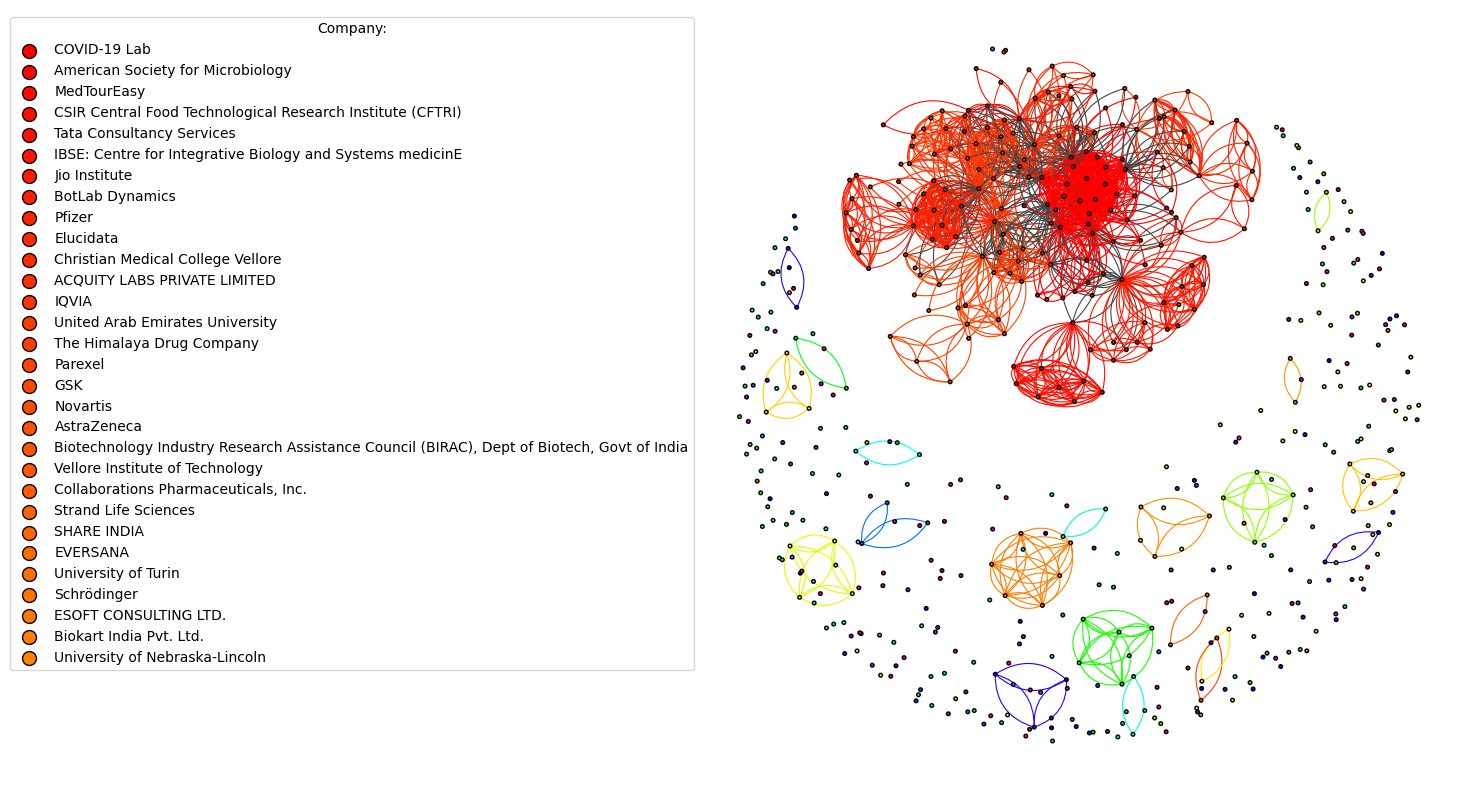

In [7]:
!pip install igraph
import igraph as ig
#Load data
df = pd.read_csv('/content/Connection_Data.csv')

#Create an empty graph
G = ig.Graph()

#Add nodes (companies) to the graph
G.add_vertices(df['Company'].unique().tolist())

#Create edges between companies that share at least one position
for company1 in df['Company'].unique():
    for company2 in df['Company'].unique():
        if company1 != company2:
            shared_positions = set(df[df['Company'] == company1]['Position']).intersection(df[df['Company'] == company2]['Position'])
            if shared_positions:
                G.add_edge(company1, company2)

#Generate communities using community_edge_betweenness
communities = G.community_edge_betweenness()

#Set attributes for the graph nodes
layout = G.layout_kamada_kawai()
G.vs["x"], G.vs["y"] = list(zip(*layout))
G.vs["size"] = 1

#Create a VertexClustering that compresses each community into a single, "composite" vertex
communities = communities.as_clustering()

#Set colors for the clusters
num_communities = len(communities)
palette1 = ig.RainbowPalette(n=num_communities)
for i, community in enumerate(communities):
    G.vs[community]["color"] = i
    community_edges = G.es.select(_within=community)
    community_edges["color"] = i

#Get a mapping of community indices to company names and their appearance frequency
company_count = {}
for vertex in G.vs:
    company_name = vertex['name']
    if company_name in company_count:
        company_count[company_name] += 1
    else:
        company_count[company_name] = 1

#Sort the companies based on their appearance frequency in descending order - top 30
top_10_companies = sorted(company_count, key=company_count.get, reverse=True)[:30]

#Plot the graph
palette2 = ig.GradientPalette("gainsboro", "black")
fig, ax = plt.subplots()
ig.plot(
    G,
    target=ax,
    palette=palette1,
    vertex_size=[max(0.2, size / 20) for size in G.vs["size"]],
    edge_color=G.es["color"],
    edge_width=0.8,
)

#Add a legend with top 10 company names
legend_handles = []
for i, company in enumerate(top_10_companies):
    handle = ax.scatter(
        [], [],
        s=100,
        facecolor=palette1.get(i),
        edgecolor="k",
        label=company,
    )
    legend_handles.append(handle)

ax.legend(
    handles=legend_handles,
    title='Company:',
    bbox_to_anchor=(0, 1.0),
    bbox_transform=ax.transAxes,
)

fig.set_size_inches(10, 10)
#plt.savefig('Community_network.png')
plt.show()

Analyze the network's properties and community structure, helpful in understanding the relationships and patterns between companies in the network

In [ ]:
#Load data from the CSV file
df = pd.read_csv('/content/Connection_Data.csv')

#Create an empty graph
G = ig.Graph()

#Add nodes (companies) to the graph
G.add_vertices(df['Company'].unique().tolist())

#Create edges between companies that share at least one position
for company1 in df['Company'].unique():
    for company2 in df['Company'].unique():
        if company1 != company2:
            shared_positions = set(df[df['Company'] == company1]['Position']).intersection(df[df['Company'] == company2]['Position'])
            if shared_positions:
                G.add_edge(company1, company2)

#Calculate the no of nodes (companies)
num_nodes = G.vcount()

#Calculate the no of edges (connections between companies)
num_edges = G.ecount()

#Calculate the density of the network
density = G.density()

#Calculate the degree distribution
degree_distribution = G.degree_distribution()

#Calculate the clustering coefficient
clustering_coefficient = G.transitivity_undirected()

#Perform community detection
communities = G.community_edge_betweenness().as_clustering()

print("Number of Nodes (Companies):", num_nodes)
print("Number of Edges (Connections):", num_edges)
print("Density of the Network:", density)
print("Degree Distribution:", degree_distribution)
print("Clustering Coefficient:", clustering_coefficient)
print("Number of Communities:", len(communities))


Number of Nodes (Companies): 555
Number of Edges (Connections): 1620
Density of the Network: 0.010537613425700068
Degree Distribution: N = 555, mean +- sd: 5.8378 +- 11.5015
Each * represents 5 items
[ 0,  1): ************************************************************** (314)
[ 1,  2):  (0)
[ 2,  3): ********* (47)
[ 3,  4):  (0)
[ 4,  5): ***** (28)
[ 5,  6):  (0)
[ 6,  7): ***** (26)
[ 7,  8):  (0)
[ 8,  9): *** (19)
[ 9, 10):  (0)
[10, 11): *** (19)
[11, 12):  (0)
[12, 13): *** (16)
[13, 14):  (0)
[14, 15): *** (18)
[15, 16):  (0)
[16, 17): *** (17)
[17, 18):  (0)
[18, 19):  (1)
[19, 20):  (0)
[20, 21): * (6)
[21, 22):  (0)
[22, 23):  (2)
[23, 24):  (0)
[24, 25): * (9)
[25, 26):  (0)
[26, 27):  (0)
[27, 28):  (0)
[28, 29):  (4)
[29, 30):  (0)
[30, 31):  (1)
[31, 32):  (0)
[32, 33):  (1)
[33, 34):  (0)
[34, 35): * (9)
[35, 36):  (0)
[36, 37):  (2)
[37, 38):  (0)
[38, 39):  (4)
[39, 40):  (0)
[40, 41):  (0)
[41, 42):  (0)
[42, 43):  (0)
[43, 44):  (0)
[44, 45):  (0)
[45, 46):  (0)
[